In [3]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Bikes 🚲

----

The data from today is about bike sharing demand from [a previously held Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand/data).  Below is a bit of documentation from the competition.

---

> You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.
>
> Data Fields
> ```
> datetime - hourly date + timestamp  
> season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
> holiday - whether the day is considered a holiday
> workingday - whether the day is neither a weekend nor holiday
> weather - 1: Clear, 
>              Few clouds,
>              Partly cloudy, 
>              Partly cloudy
>           2: Mist + Cloudy, 
>              Mist + Broken clouds, 
>              Mist + Few clouds,
>              Mist
>           3: Light Snow,
>              Light Rain + Thunderstorm + Scattered clouds, 
>              Light Rain + Scattered clouds
>           4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, 
>              Snow + Fog 
> temp - temperature in Celsius
> atemp - "feels like" temperature in Celsius
> humidity - relative humidity
> windspeed - wind speed
> casual - number of non-registered user rentals initiated
> registered - number of registered user rentals initiated
> count - number of total rentals
> ```

From this list of column descriptions.

* What columns are categorical?  Which of these do you think we'll need to one-hot-encode?
* Do you see any columns that you expect to be multicollinear?

In the Kaggle competition the challenge was to predict the `count` column.  The `casual` and `registered` columns aren't allowed to be used since that information is really just the `count` column broken out into its components (i.e. `count = casual + registered`).

In [4]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders import LeaveOneOutEncoder

# Import supervised model types here:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Import dask modules here:
import joblib
from dask.distributed import Client, progress
from dask_ml.model_selection import train_test_split
import dask.dataframe as dd
import dask.array as da
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [5]:
def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

### Let's do some general EDA

In [6]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit="2GB")
client

Client Scheduler: tcp://127.0.0.1:58619 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GB


<IPython.core.display.Javascript object>

In [7]:
# data from https://www.kaggle.com/c/bike-sharing-demand/data
data_url = "https://docs.google.com/spreadsheets/d/1GJrx_Y3cvD1sWLg_zF_mMZZ0iZ_If2E02VIkyCi3PTc/export?format=csv"
# df = pd.read_csv(data_url)
# df_og = df.copy()

df = dd.read_csv(data_url)

df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
npartitions=1,,,,,,,,,,,,
,object,int64,int64,int64,int64,float64,float64,int64,float64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...


<IPython.core.display.Javascript object>

The column `datetime` itself isn't very useful.  Why is that and how might we get some useful info out of the column?

In [5]:
df["datetime"] = dd.to_datetime(df["datetime"])
df["hour"] = df["datetime"].dt.hour
df["weekday_num"] = df["datetime"].dt.weekday
df["weekday_name"] = df["datetime"].dt.day_name()
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday_num,weekday_name
npartitions=1,,,,,,,,,,,,,,,
,datetime64[ns],int64,int64,int64,int64,float64,float64,int64,float64,int64,int64,int64,int64,int64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<IPython.core.display.Javascript object>

Drop the datetime column

In [6]:
df = df.drop(columns="datetime")

<IPython.core.display.Javascript object>

Investigate the column datatypes to make sure there's nothing unexpected

In [ ]:
# df.info().compute()
# df.info()
# df.describe()
df.describe().compute()

Do we have missing values we need to handle?

In [ ]:
df.isna().mean().compute()

Calculate summary statistics.  When doing this, pay extra attention to our response variable, `count`.

In [ ]:
df.describe().compute()["count"]

Plot a `scatter_matrix`/`pairplot` of our dataframe

In [ ]:
# sns.pairplot(df.compute())
# plt.show()

Some things to point out.

* Its not the strongest thing, but, temperature seems to have an effect on rentals (the higher the temp the more rentals).  This effect seems more prominent in the casual rentals.
* Both humidity and windspeed seem to have negative effects.  When they're low, there doesn't seem to be a big correlation, but when these factors are high we see a drop off in rentals.
* We won't be using this information, but note the plots between casual & count.  We see a pretty distinct v-shape, this is indicative of an interaction happening somewhere.  That is, there seems to be 2 distinct groups of data, we could try and explore and find a reason for this split.
* Our response variable `count` is a very positively skewed distribution.  This indicates that we might want to perform a transformation to it.  For now we'll leave it, and come back to this.

Plot the distribution of the response

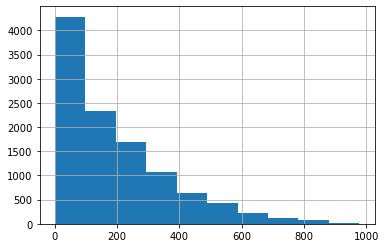

<IPython.core.display.Javascript object>

In [7]:
df["count"].compute().hist()
plt.show()

## Prep data for modeling

In [8]:
drop_cols = [
    "count",
    "registered",
    "casual",
    "weekday_num",
    "atemp",
    "workingday",
]

X = df.drop(columns=drop_cols)
y = da.log(df["count"])

<IPython.core.display.Javascript object>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

<IPython.core.display.Javascript object>

In [12]:
type(X_train)

dask.dataframe.core.DataFrame

<IPython.core.display.Javascript object>

In [ ]:
X_train.head(2)

In [17]:
num_cols = [
    "season",
    "weather",
    "temp",
    "humidity",
    "windspeed",
]

bin_cols = ["holiday"]

cat_cols = ["hour", "weekday_name"]
drop_cats = [0, "Monday"]

<IPython.core.display.Javascript object>

## Train a model to predict `count`

In [13]:
i = 1

<IPython.core.display.Javascript object>

In [18]:
# fmt: off
preprocessing = ColumnTransformer([
    ("scale", StandardScaler(), num_cols),
    ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
], remainder="passthrough")

<IPython.core.display.Javascript object>

In [19]:
estimators = [
    XGBRegressor(),
    KNeighborsRegressor(),
    RandomForestRegressor(),
    SVR(),
    ElasticNet(),
]

<IPython.core.display.Javascript object>

In [20]:
# fmt: off
pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ('model', estimators[i]),
])

<IPython.core.display.Javascript object>

In [ ]:
# fmt: off
# single model cell.
# 
# pipeline = Pipeline([
#     ("preprocessing", preprocessing),
#     ('model', estimators[i]),
# ])
# grids = [
#     {
#         "model__max_depth": [3, 5, 10],
#         "model__subsample": [0.5, 0.75, 1],
#     }

In [21]:
grids = [
    {
        "model__max_depth": [3, 5, 10],
        "model__subsample": [0.5, 0.75, 1],
    },
    {"model__n_neighbors": [3, 5, 7], "model__weights": ["uniform", "distance"]},
    {"model__n_estimators": [30, 50, 100, 150], "model__max_depth": [5, 10, 15, 20]},
    {"model__kernel": ["linear", "rbf"], "model__epsilon": [0.5, 1.0, 2.0]},
    {"model__alpha": [0.5, 1, 1.5, 2], "model__l1_ratio": [0.25, 0.5, 0.75, 1.0]},
]

<IPython.core.display.Javascript object>

In [22]:
pipeline_cv = GridSearchCV(pipeline, grids[i], verbose=1, n_jobs=-1, cv=2)

<IPython.core.display.Javascript object>

In [23]:
with joblib.parallel_backend("dask"):
    pipeline_cv.fit(X_train.compute(), y_train.compute())

print(f"Train Score: {pipeline_cv.score(X_train.compute(), y_train.compute())}")
print(f"Test Score: {pipeline_cv.score(X_test.compute(), y_test.compute())}")

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   56.2s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   58.4s finished


Train Score: 0.99976885166609
Test Score: 0.7654990358135848


<IPython.core.display.Javascript object>

In [1]:
def get_best_model(x, y, x_test, y_test):

    """Function returns train/test scores and top-scoring
    parameters of the ones that are listed below"""

    train_scores = []
    test_scores = []
    best_params = []

    estimators = [
        #         XGBRegressor(),
        KNeighborsRegressor(),
        RandomForestRegressor(),
        SVR(),
        ElasticNet(),
    ]

    preprocessing = ColumnTransformer(
        [
            ("scale", StandardScaler(), num_cols),
            ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
        ],
        remainder="passthrough",
    )

    grids = [
        #         {
        #             "model__max_depth": [3, 5, 10],
        #             "model__n_estimators": [30, 50, 100, 150],
        #             "model__subsample": [0.1, 0.25, 0.5, 0.75, 1],
        #         },
        {"model__n_neighbors": [3, 5, 7], "model__weights": ["uniform", "distance"]},
        {
            "model__n_estimators": [30, 50, 100, 150],
            "model__max_depth": [5, 10, 15, 20],
        },
        {"model__kernel": ["linear", "rbf"], "model__epsilon": [0.5, 1.0, 2.0]},
        {"model__alpha": [0.5, 1, 1.5], "model__l1_ratio": [0.5, 0.75, 1.0]},
    ]
    for i, estimator in enumerate(estimators):
        pipeline = Pipeline(
            [
                ("preprocessing", preprocessing),
                ("model", estimator),
            ]
        )
        pipeline_cv = GridSearchCV(
            pipeline, param_grid=grids[i], verbose=1, n_jobs=-1, cv=2
        )

        with joblib.parallel_backend("dask"):
            pipeline_cv.fit(x.compute(), y.compute())

        train_scores.append(pipeline_cv.score(x.compute(), y.compute()))
        test_scores.append(pipeline_cv.score(x_test.compute(), y_test.compute()))
        best_params.append(pipeline_cv.best_params_)
    scores_df = pd.DataFrame(
        [estimators, train_scores, test_scores],
        columns=["Algorithm", "Training Scores", "Testing Scores"],
    )

    return scores_df

In [2]:
get_best_model(x=X_train, y=y_train, x_test=X_test, y_test=y_test)

NameError: name 'X_train' is not defined

In [ ]:
pipeline_cv.best_estimator_

In [ ]:
pipeline_cv.best_estimator_["model"].feature_importances_

## Evaluate perfomance and adjust your strategy as needed

In [ ]:
y_pred = pipeline_cv.predict(X_test.compute())

In [ ]:
y_test.head()

In [ ]:
dir(y_test)


In [ ]:
y_test_exp = da.exp(y_test)
y_pred_exp = da.exp(y_pred)

In [ ]:
mae = da.mean(da.absolute(y_pred_exp.compute() - y_test_exp.compute()))
mape = da.mean(
    da.absolute((y_pred_exp.compute() - y_test_exp.compute()) / y_test_exp.compute())
)

print(f"MAE: {mae.compute():.2f}")
print(f"MAPE: {100 * mape.compute:.2f}%")

In [ ]:
ymin = y_test.min()
ymax = y_test.max()

plt.scatter(y_test, y_pred)
plt.plot([ymin, ymax], [ymin, ymax], c="red")
plt.show()

In [ ]:
pred_df = df_og.loc[X_test.index, :].copy()
pred_df["y_true"] = y_test_exp
pred_df["y_pred"] = y_pred_exp
pred_df["resid"] = pred_df["y_pred"] - pred_df["y_true"]
pred_df["abs_resid"] = pred_df["resid"].abs()

pred_df = pred_df.sort_values("abs_resid", ascending=False)
pred_df.head(5)